## Imports & setup

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

## O que tem nos csvs?

In [3]:
# Visualização básica da informação
def sep():
    print('---')

testDf = pd.read_csv('../input/nlp-getting-started/test.csv')
trainDf = pd.read_csv('../input/nlp-getting-started/train.csv')

testInfo = [testDf.size, testDf['text'],testDf['keyword'].isna().sum(), testDf['location'].isna().sum()]
trainInfo = [trainDf.size, testDf['text'],testDf['keyword'].isna().sum(), testDf['location'].isna().sum()]

print(testDf.head())
sep()
print(testInfo)
sep()
print(trainInfo)
sep()

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
---
[13052, 0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Haz

## EDA

<AxesSubplot:>

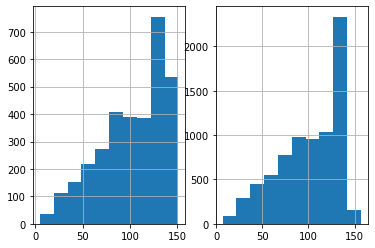

In [6]:
# Como fazer EDA em NLP? 
# https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
# https://towardsai.net/p/nlp/natural-language-processing-concepts-and-workflow-48083d2e3ce7

plt.subplot(121)
testDf['text'].str.len().hist()
plt.subplot(122)
trainDf['text'].str.len().hist()
# Distribuição similar no comprimento dos tweets

In [58]:
# Mostrar 1 exemplo aleatorio positivo e negativo:
negativo = np.where(trainDf['target']==0)
positivo = np.where(trainDf['target']==1)
naoEhDesastre = trainDf.loc[negativo[0][np.random.randint(0,np.shape(negativo)[1])]]
ehDesastre = trainDf.loc[positivo[0][np.random.randint(0,np.shape(positivo)[1])]]

print(naoEhDesastre.text,", TARGET = ",naoEhDesastre.target)
print(ehDesastre.text,", TARGET = ",ehDesastre.target)
print('\n ----- \n')

# mostrar 10 aleatorios
for i in range(9):
    indice = np.random.randint(low =0,high = trainDf['text'].size)
    print(trainDf.loc[indice].text,", TARGET = ",trainDf.loc[indice].target)

# => precisamos tokenizar / stopwords para tweets+pontuação+links+entidades html (&gt; &nbsp; etc...)

Finna storm. Fuck my back boutta start hurting like a mf ?????? , TARGET =  0
Another hour! It's August 05 2015 at 08:02PM Here's Red Rover Zombie Apocalypse 2014! http://t.co/cf9e6TU3g7 #internetradio #collegeradiÛ_ , TARGET =  1

 ----- 

Me trying to pass lax with my family ends up by me having to run after the ball after it gets bombed over my head , TARGET =  0
|| So.... I just watched the trailed for The Dust Storm and I think part of me just died.... Colin is so perfect my goodness. , TARGET =  0
Former heroin addict shares story as city leaders sound alarm: City officials said emergency teams responded t... http://t.co/GZxIPMOknB , TARGET =  1
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.' , TARGET =  0
Them shootas be so hungry with bodies on they burner ?? , TARGET =  0
'Invading Iraq was a catastrophic mistake'.

Diplomacy needs to replace constant threat of war by US and Israel:

http://t.co/yqjpn3qUUX , T

In [98]:
# regex para remover htmlm, 
# source: https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model
import re,string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train = trainDf.copy()
train['text'] = train['text'].apply(lambda x:clean_text(x))


In [99]:
# pegar estatistica de sentimento a partir de modelo bom

from transformers import pipeline
sentiment = pipeline("sentiment-analysis")
sentiment("wow I LOVE maths")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


[{'label': 'POSITIVE', 'score': 0.9998286962509155}]

In [101]:
a = sentiment("wow I LOVE maths")
print(0 if a[0]['label']=='NEGATIVE' else 1)

b = sentiment("wow I HATE maths")
print(0 if b[0]['label']=='NEGATIVE' else 1)

def sentimento_bert(texto):
    return 0 if sentiment(texto)[0]['label']=='NEGATIVE' else 1
    

train['sentiment'] = train['text'].apply(lambda x:sentimento_bert(x))

train.head(10)

1
0


,id,keyword,location,text,target,sentiment
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,0
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1,0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,0
5,8,NaN,NaN,rockyfire update california hwy closed in bo...,1,0
6,10,NaN,NaN,flood disaster heavy rain causes flash floodin...,1,0
7,13,NaN,NaN,im on top of the hill and i can see a fire in ...,1,1
8,14,NaN,NaN,theres an emergency evacuation happening now i...,1,0
9,15,NaN,NaN,im afraid that the tornado is coming to our area,1,0


<AxesSubplot:title={'center':'TARGET=1'}, ylabel='id'>

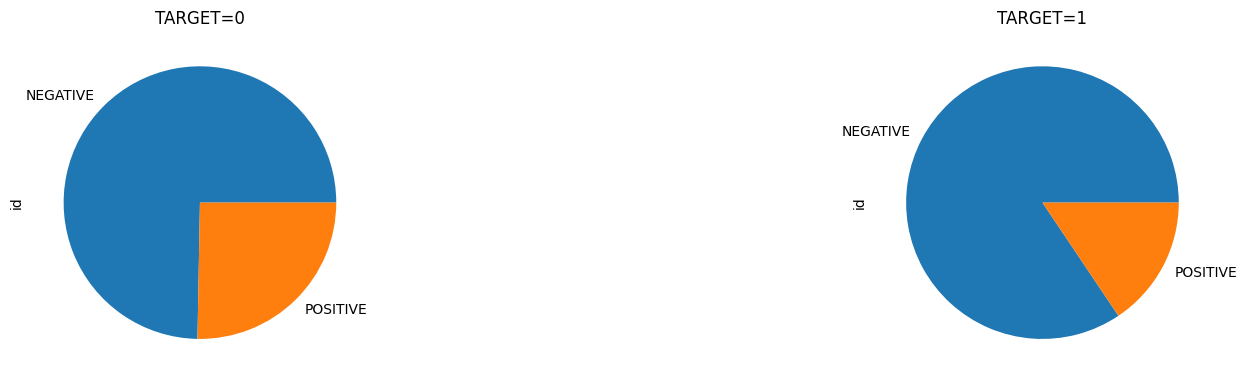

In [106]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train.loc[np.where(train['target']==0)].groupby('sentiment').count()['id'].plot(title='TARGET=0',kind='pie', ax=axes[0], labels=['NEGATIVE', 'POSITIVE'])
train.loc[np.where(train['target']==1)].groupby('sentiment').count()['id'].plot(title='TARGET=1',kind='pie', ax=axes[1], labels=['NEGATIVE', 'POSITIVE'])

## Replicando metodologia já usada, para ver impacto:

In [109]:
tweets = train['text']

In [148]:
import shap # shap para criar indicadores de feature importance
from tqdm.notebook import tqdm # tqdm para criar uma barra de loading enquanto estiver num loop

import nltk # biblioteca de nlp
from nltk.tokenize import word_tokenize, TweetTokenizer # funções de tokenização
from nltk.corpus import twitter_samples, stopwords # fuções para acessar algumas bases do nltk

nltk.download('twitter_samples') # base de dados com amostras do twitter
nltk.download('punkt') # recursos de tokenização
nltk.download('stopwords') # lista de stopwords
tweet_tokenizer = TweetTokenizer() # fução específica para tokenizar tweets
from sklearn.model_selection import cross_val_score, train_test_split # funções que ajudam a escolher os modelos
from sklearn.metrics import confusion_matrix, f1_score # Métricas para avaliar um modelo de classificação
from sklearn.naive_bayes import GaussianNB # Modelo Naive Bayes com Gaussian
from sklearn.tree import DecisionTreeClassifier # Modelo Decision Tree to Classifier
from sklearn.ensemble import RandomForestClassifier # Modelo Random Forest and Adaboost 

import plotly.graph_objs as go # Para criar os gráficos

# Preprocessando com NLTK
emojis = [':(', ':-(', '(', ')','>:-(', ':)', ':-)','?','!','...','û_',':','-']
stop_words = stopwords.words('english')+emojis

def count_vect(vect:list, 
               vocab:dict(), 
               stop_words:list=None, 
               lower_case:bool=False,
               skeep_not_found:bool=False,
               )->dict:
  """Função que recebe a lista de tokens, os agrupa e gera o vocabulário

    Args:
        vect (list): lista de tokens de uma amostra
        vocab (dict): vocabulário já existente
        stop_words (list, optional): Lista de stopwords a serem ignoradas. Defaults to None.
        lower_case (bool, optional): Se forçará lower-case em todos os tokens. Defaults to False.
        skeep_not_found (bool, optional): Se ignorará termos que ainda não existem no vocabulário. Defaults to False.

    Returns:
        dict: dicionário contendo os termos da lista de tokens e a frequência
  """

  ct_vect = {}
  # percorre cada token
  for w in vect:
    # se vai forçar lower-case
    if lower_case:
      w = w.lower()
    # ignorando stop_words
    if stop_words:
      if w in stop_words:
        continue
    # se vai ignorar termos não existentes no discionário
    if skeep_not_found:
      if w not in vocab:
        continue
    # adiciona termo novo ao vocabulário e incrementa a frequência
    if w not in vocab:
      vocab[w] = 0
    vocab[w] += 1
    # Adiciona o termo ao discionário de tokens e frequência
    if w not in ct_vect:
      ct_vect[w] = 0
    ct_vect[w] += 1
  return ct_vect

def tokenize_data(list_text:list, stop_words:list=None)->[list, dict]:
  """Recebe lista de strings, stopwords e os transforma em uma lista de discionários de termos e frequência.
  Retornando também o vocabulário encontrado

  Args:
      list_text (list): lista de strings a serem processadas
      stop_words (list, optional): lista de stopwords a serem ignorados. Defaults to None.

  Returns:
      tuple[list, dict]: o primeiro valor é uma lista de discionários com termo e frequência, o segundo valor é o vocabulário com a frequência de todo corpus
  """

  vocab = dict()
  tk_text = []
  
  # itera em cada documento, chamando a função count_vect
  for t in list_text:
    new_t = count_vect(tweet_tokenizer.tokenize(t), vocab, stop_words=stop_words, lower_case=True)
    tk_text.append(new_t)

  return tk_text, vocab

def to_matrix(tk_text:list, vocab:dict)->[list, dict]:
  """Gera uma matriz bag-of-words dos termos identificados e retorna o vocabulário utilizado

    Args:
        tk_text (list): lista de discionários com termo e frequência
        vocab (dict): o vocabulário com a frequência de todo corpus

    Returns:
        tuple[list, dict]: matriz bag-of-words e vocabulário usado
    """
  matrix = []
  temp_vocab = vocab.keys()
  # percorre cada documento
  for text in tqdm(tk_text):
    new_text = []
    # percorre cada termo do vocabulário
    for word in temp_vocab:
      # atribui a frequência encontrada ou zero caso contrário
      if word in text:
        # grava a frequência
        new_text.append(text[word])
      else:
        new_text.append(0)

    matrix.append(new_text)

  return matrix, temp_vocab


def to_predict(text:str, vocab:dict, stop_words:list=None):
  """Transforma um texto em bag-of-words pronto para o modelo

  Args:
      text (str): string a ser transformada
      vocab (dict): vocabulário usado
      stop_words (list, optional): lista de stop_words a serem ignorada. Defaults to None.

  Returns:
      _type_: matriz bag-of-words
  """
  # chamo a função count_vect com skeep_not_found igual a true, não queremos aumentar nosso vocabulário aqui
  new_t = count_vect(tweet_tokenizer.tokenize(text), 
                      vocab, 
                      stop_words=stop_words, 
                      lower_case=True, 
                      skeep_not_found=True)
  # com isso basta chamar to_matrix
  matrix, _ = to_matrix([new_t], vocab)
  return matrix

def train_models(matrix, labels):
  
  # Dividindo o dado em treino e teste
  X_train, X_test, y_train, y_test = train_test_split(matrix, labels, test_size=0.2, random_state=42)

  # lista de modelos a serem testados
  models = [GaussianNB(),
            DecisionTreeClassifier(max_depth=50),          
            RandomForestClassifier(max_depth=50, n_estimators=50),
          ]

  # nome dos modelos
  models_name = ["Naive Bayes", "Decision Tree", "Random Forest"]


  # discionários para guardar informações do treinamento
  total_scores = {}
  trained_models = {}
  # for iterando por modelo
  for model, model_name in zip(models, models_name):
      np.random.seed = 42
      # cross validation
      scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1')
      # registra o score médio e o desvio padrão da validação cruzada
      total_scores[model_name] = [scores, scores.mean(), scores.std()]
      # F1 Score
      print("{} -- Training K-Fold mean f1: {:0.3f} (std: {:0.3f})".format(model_name, scores.mean(), scores.std()))
      # Testa o modelo com dados
      y_pred = model.fit(X_train,y_train).predict(X_test)

        
      # Matriz de confusão
      z = confusion_matrix(y_test, y_pred)
      x=['Negative', 'Positive']
      y=['Negative', 'Positive']
      
      # Gerando gráfico no plotly
      annotations = []
      for n, row in enumerate(z):
          for m, val in enumerate(row):
              annotations.append(go.layout.Annotation(text=str(z[n][m]), x=x[m], y=y[n],
                                              xref='x1', yref='y1', showarrow=False))
              
      data = [go.Heatmap(x=x,y=y,z=z,colorscale=["white", "lightblue"])] #amp blues peach

      layout = go.Layout(title='Confusion Matrix - {}'.format(model_name),
                         xaxis={'title' : 'Predicted label'},
                         yaxis={'autorange' : 'reversed','title' : 'True Label'})
      
      fig = go.Figure(data=data, layout=layout)
      fig['layout'].update(annotations=annotations, height=350, width=350)
      fig.show()
      # fim da geração do gráfico

      print("{} -- Test f1: {:0.3f}".format(model_name, f1_score(y_test, y_pred)))
      print('----------------------------------------------------------------------------')
      trained_models[model_name] = model

  return trained_models, total_scores, X_test

def train_models2(matrix, labels):
  
  # Dividindo o dado em treino e teste
  X_train, X_test, y_train, y_test = train_test_split(matrix, labels, test_size=0.2, random_state=42)

  # lista de modelos a serem testados
  models = [
            DecisionTreeClassifier(),          
            RandomForestClassifier(),
          ]

  # nome dos modelos
  models_name = ["Decision Tree", "Random Forest"]


  # discionários para guardar informações do treinamento
  total_scores = {}
  trained_models = {}
  # for iterando por modelo
  for model, model_name in zip(models, models_name):
      np.random.seed = 42
      # cross validation
      scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1')
      # registra o score médio e o desvio padrão da validação cruzada
      total_scores[model_name] = [scores, scores.mean(), scores.std()]
      # F1 Score
      print("{} -- Training K-Fold mean f1: {:0.3f} (std: {:0.3f})".format(model_name, scores.mean(), scores.std()))
      # Testa o modelo com dados
      y_pred = model.fit(X_train,y_train).predict(X_test)

        
      # Matriz de confusão
      z = confusion_matrix(y_test, y_pred)
      x=['Negative', 'Positive']
      y=['Negative', 'Positive']
      
      # Gerando gráfico no plotly
      annotations = []
      for n, row in enumerate(z):
          for m, val in enumerate(row):
              annotations.append(go.layout.Annotation(text=str(z[n][m]), x=x[m], y=y[n],
                                              xref='x1', yref='y1', showarrow=False))
              
      data = [go.Heatmap(x=x,y=y,z=z,colorscale=["white", "lightblue"])] #amp blues peach

      layout = go.Layout(title='Confusion Matrix - {}'.format(model_name),
                         xaxis={'title' : 'Predicted label'},
                         yaxis={'autorange' : 'reversed','title' : 'True Label'})
      
      fig = go.Figure(data=data, layout=layout)
      fig['layout'].update(annotations=annotations, height=350, width=350)
      fig.show()
      # fim da geração do gráfico

      print("{} -- Test f1: {:0.3f}".format(model_name, f1_score(y_test, y_pred)))
      print('----------------------------------------------------------------------------')
      trained_models[model_name] = model

  return trained_models, total_scores, X_test


# tokenizar e criar o vocabulario
tk_text2, vocab2 = tokenize_data(tweets, stop_words)

min_used = 2
for word in vocab2.copy():
  if vocab2[word] < min_used:
    del vocab2[word]

# criar a matriz bag-of-words
matrix2, columns2 = to_matrix(tk_text2, vocab2)
# convertendo a matriz para um array numpy
matrix2 = np.array(matrix2)
print(matrix2.shape)
# visualizando uma amostra
pd.DataFrame(matrix2[0:10], columns=columns2)

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/7613 [00:00<?, ?it/s]

(7613, 6263)


,deeds,reason,earthquake,may,allah,forgive,us,forest,fire,near,...,kashmir,bullet,woodlawn,friggin,sequel,conclusively,furious,wrecked,cramer,igers
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
labels=train['target']

In [139]:
%%time
trained_models2, total_scores2, X_test2 = train_models(matrix2, labels)

Naive Bayes -- Training K-Fold mean f1: 0.645 (std: 0.010)


Naive Bayes -- Test f1: 0.652
----------------------------------------------------------------------------
Decision Tree -- Training K-Fold mean f1: 0.636 (std: 0.012)


Decision Tree -- Test f1: 0.618
----------------------------------------------------------------------------
Random Forest -- Training K-Fold mean f1: 0.614 (std: 0.009)


Random Forest -- Test f1: 0.617
----------------------------------------------------------------------------
CPU times: user 1min 25s, sys: 1.16 s, total: 1min 27s
Wall time: 1min 27s


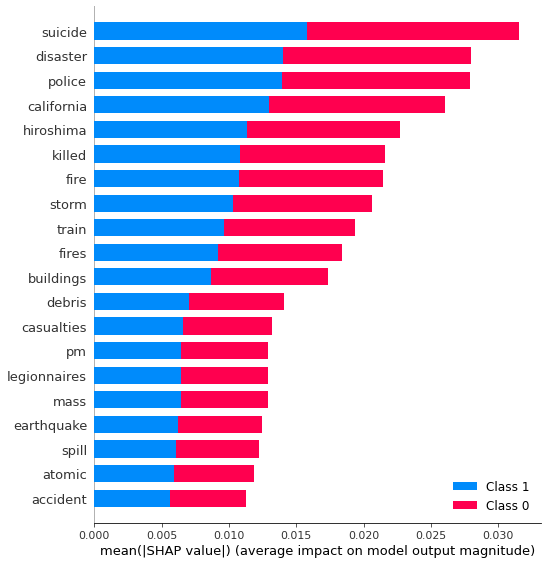

In [140]:
model_name = 'Decision Tree'
# criando um dataframe para sair bacana no plot
df_x_test = pd.DataFrame(X_test2, columns=columns2)
df_x_test['sentiment']=train['sentiment']
# passa para o shap o modelo e os dados para ele avaliar e gerar indicadores
shap_values = shap.TreeExplainer(trained_models2[model_name]).shap_values(df_x_test)
# plota um gráfico mostrando os termos mais importantes para o modelo
shap.summary_plot(shap_values,df_x_test)

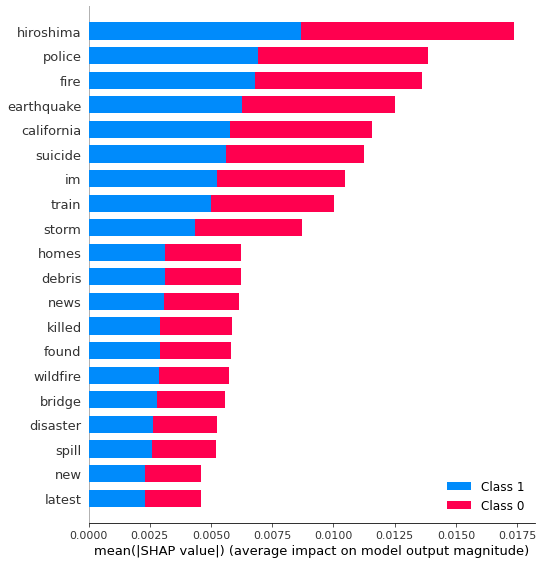

In [141]:
model_name = 'Random Forest'
# criando um dataframe para sair bacana no plot
df_x_test = pd.DataFrame(X_test2, columns=columns2)
# passa para o shap o modelo e os dados para ele avaliar e gerar indicadores
shap_values = shap.TreeExplainer(trained_models2[model_name]).shap_values(df_x_test.head(50))
# plota um gráfico mostrando os termos mais importantes para o modelo
shap.summary_plot(shap_values,df_x_test)

In [144]:
outro = pd.DataFrame(matrix2, columns=columns2)
outro['sentiment'] = train['sentiment']
outro.drop('target',1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



,deeds,reason,earthquake,may,allah,forgive,us,forest,fire,near,...,bullet,woodlawn,friggin,sequel,conclusively,furious,wrecked,cramer,igers,sentiment
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
%%time
trained_models3, total_scores3, X_test3 = train_models2(outro, labels)

Decision Tree -- Training K-Fold mean f1: 0.691 (std: 0.005)


Decision Tree -- Test f1: 0.651
----------------------------------------------------------------------------
Random Forest -- Training K-Fold mean f1: 0.724 (std: 0.010)


Random Forest -- Test f1: 0.700
----------------------------------------------------------------------------
CPU times: user 1min 58s, sys: 605 ms, total: 1min 58s
Wall time: 1min 58s


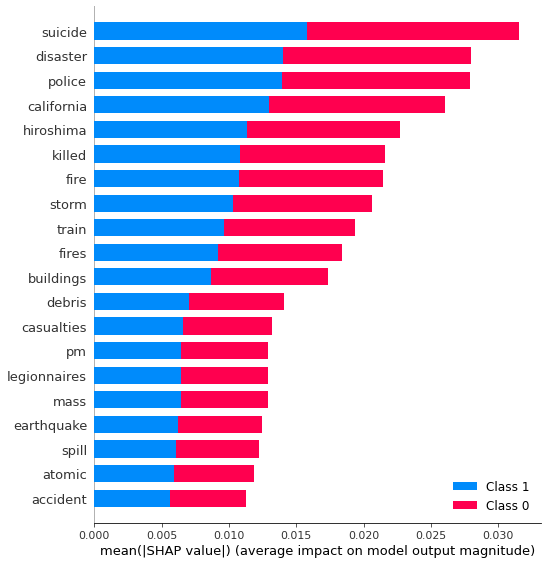

In [151]:
model_name = 'Decision Tree'
# criando um dataframe para sair bacana no plot
df_x_test = pd.DataFrame(X_test3, columns=outro.columns)
df_x_test['sentiment']=train['sentiment']
# passa para o shap o modelo e os dados para ele avaliar e gerar indicadores
shap_values = shap.TreeExplainer(trained_models3[model_name]).shap_values(df_x_test)
# plota um gráfico mostrando os termos mais importantes para o modelo
shap.summary_plot(shap_values,df_x_test)

In [ ]:
model_name = 'Random Forest'
# criando um dataframe para sair bacana no plot
df_x_test = pd.DataFrame(X_test3, columns=outro.columns)
# passa para o shap o modelo e os dados para ele avaliar e gerar indicadores
shap_values = shap.TreeExplainer(trained_models3[model_name]).shap_values(df_x_test.head(50))
# plota um gráfico mostrando os termos mais importantes para o modelo
shap.summary_plot(shap_values,df_x_test)

In [ ]:
outro.columns

In [ ]:
import lightgbm as lgb

X_train4, X_test4, y_train4, y_test4 = train_test_split(outro, labels, test_size=0.2, random_state=42)
d_train = lgb.Dataset(X_train4, label=y_train4)
d_test = lgb.Dataset(X_test4, label=y_test4)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values4 = explainer.shap_values(outro)
shap.summary_plot(shap_values4, outro)